# Description


This notebook contains code of post <>, that talks about comparing the quality of autoencoder filter against the traditional methods of median, mean and majority filters.

Autoencoder [1] are neural networks that given an input compress this input in an lower dimention and tries to reconstruct that input with this lower information. An denoise autoencoder thus is an autoencoder that recieves an image with noise compress this noised image and so tries to reconstruct that image without noise.

The autoencoders are formed of two parts, one is the encoder that compress the data, an the another is the decoder, that expand the dimention space of the data.

The dataset used for this experiment is the CelebFaces dataset set, that contains images of celebrity faces. The method used for train the autoencoder is to apply some random normal noise in the dataset images and then tries to make the autoencoder predicts the image without noise. The metric used to compare the resuts of autoencoder and the filter is the F1 score that compares the image of dataset without noise with the image with noise removed by these tecnics.

![image.png](http://mmlab.ie.cuhk.edu.hk/projects/CelebA/overview.png)


[1] Lu, X., Tsao, Y., Matsuda, S., & Hori, C. (2013, August). Speech enhancement based on deep denoising autoencoder. In Interspeech (pp. 436-440).

# Prepare data

In [0]:
import zipfile
import numpy as np
max_files = 10000

zip_file = zipfile.ZipFile('dataset/img_align_celeba.zip','r')
files = list(zip_file.namelist())
selected_files = np.random.choice(files, 10000)
for file in selected_files:
  zip_file.extract(file, 'dataset/images/')
zip_file.close()

In [0]:
import os
batch_size = 1000
files_path = "dataset/images"
files_names = os.listdir(files_path)
max_size = len(files_names)//batch_size * batch_size
files_names = files_names[:max_size]
batchs_files = np.split(np.array(files_names), len(files_names)//batch_size)

for i,batch in enumerate(batchs_files):
  imgs = []
  for file_name in batch:
    imgs.append(np.array(Image.open(f"{files_path}/{file_name}")))
  
  imgs = np.array(imgs, dtype="uint8")
  np.save(f"dataset/batch_{i}.npy", imgs)

# Import and mount google drive

In [1]:
#@title Mount drive

import os
from google.colab import drive
from functools import partial

drive.mount('/drive')
os.chdir('/drive/My Drive/Projects/Image autoencoder denoise filter')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [0]:
#@title Imports

import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split

sns.set_style("darkgrid")

from PIL import Image

In [0]:
#@title constants


img_width = 256
img_height = 256
channels = 3
max_files = 20

# Functions

In [0]:
#@title Ploting

def show_images_grid(w, h,*images, titles = [], **fig_kwargs):
  fig = plt.figure(**fig_kwargs)
  cont = 1
  for i,image in enumerate(images):
    subplot = fig.add_subplot(w, h, cont)
    subplot.imshow(image)
    subplot.set_xticks([])
    subplot.set_yticks([])
    if len(titles) != 0:
      subplot.set_title(titles[i])
    cont+=1

def show_autoencoder_results(testX, testY, autoencoder, rows = 2, columns = 10):
  imgs = []
  num_imgs = rows  * columns
  seleted_idxs = np.random.choice(range(len(testX)), num_imgs, False)
  imgs_testX = testX[seleted_idxs]
  imgs_testY = testY[seleted_idxs]
  imgs_pred = autoencoder.predict(imgs_testX)
  fig_width,fig_height = rows*5, columns*2 

  for img_testX, img_testY, img_pred in zip(imgs_testX, imgs_testY, imgs_pred):
    imgs = imgs + [img_testX, img_testY, img_pred]

  show_images_grid(columns, rows * 3, *imgs, figsize=(fig_width,fig_height))

  


In [0]:
#@title Pre-processing functions

def get_concat_h(im_1, im_2):
  if "float" in str(im_1.dtype):
    im_1 = (im_1 * 255).astype("uint8")
  if "float" in str(im_2.dtype):
    im_2 = (im_2 * 255).astype("uint8")
  im1 = Image.fromarray(im_1)
  im2 = Image.fromarray(im_2)
  dst = Image.new('RGB', (im1.width + im2.width, im1.height))
  dst.paste(im1, (0, 0))
  dst.paste(im2, (im1.width, 0))
  return np.array(dst)


In [0]:
#@title Evaluation functions

def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err


def absolute_error(imageA, imageB):
	err = np.sum(abs(imageA.astype("float") - imageB.astype("float")))
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	return err

def evaluate(imgs, imgs_filter, evaluation_func=absolute_error):
  results = [evaluation_func(img, img_filter) for img, img_filter in zip(imgs, imgs_filter)]

  return results

In [0]:
#@title Noise functions

def normal_noise(data):
  data_noise = np.random.normal(loc=0.5, scale=0.5, size=dataset.shape)
  data_noise = np.clip(data + data_noise, 0, 1)
  return dataset_noise

def gauss_noise(image):
  row,col,ch= image.shape
  mean = 0
  var = 0.01
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = np.clip(image + gauss, 0, 1)
  return noisy

def salt_pepper(image):
  row,col,ch = image.shape
  s_vs_p = 0.5
  amount = 0.03
  out = np.copy(image)
  # Salt mode
  num_salt = np.ceil(amount * image.size * s_vs_p)
  coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
  out[coords] = 1
  # Pepper mode
  num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
  coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
  out[coords] = 0
  return out

def poisson(image):
  vals = len(np.unique(image))
  vals = 2 ** np.ceil(np.log2(vals))
  noisy = np.random.poisson(image * vals) / float(vals)
  noisy = np.clip(noisy, 0, 1)
  return noisy

def speckle(image):
  row,col,ch = image.shape
  gauss = np.random.randn(row,col,ch)
  gauss = gauss.reshape(row,col,ch)        
  noisy = image + image * gauss
  noisy = np.clip(noisy, 0, 1)
  return noisy

def apply_noise(data, func):
  print(len(data))
  data = np.array([func(img) for img in data])
  print(data.shape)
  return data



In [0]:
#@title Filter functions

import itertools
from collections import Counter
from skimage.filters import rank
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value

def hsv_value_int(filter, image, *args, **kwargs):
  return (hsv_value(filter, image, *args, **kwargs) * 255).astype(int)

@adapt_rgb(hsv_value_int)
def median_each(image):
    return rank.median(image)

@adapt_rgb(hsv_value_int)
def mean_each(image):
    return rank.mean(image, selem = np.ones((3,3)))

@adapt_rgb(hsv_value_int)
def majority_filter(image):
  return rank.majority(image, selem = np.ones((3,3)))

def majority_filter_v2(image):
    def most_common(lst):
        data = Counter(lst)
        return max(lst, key=data.get)

    array = []
    width, height = image.shape[0], image.shape[1]

    for i in range(len(image)):
        row = []
        for j in range(len(image[i])):
            pixels_around = [] 

            for sum_i, sum_j in itertools.product([0, 1, -1], [0, 1, -1]):
                indx = i+sum_i
                indy = j+sum_j
                if indx >= 0 and indx < width and indy >=0 and indy < height:
                    if isinstance(image[indx][indy], list) or isinstance(image[indx][indy], np.ndarray):
                        pixels_around.append(tuple(image[indx][indy]))
                    else:
                        pixels_around.append(image[indx][indy])

            row.append(most_common(pixels_around))

        array.append(row)

    return np.array(array)


def apply_filter(data, filter_func):
  return np.array([filter_func(img) for img in data])


# load data

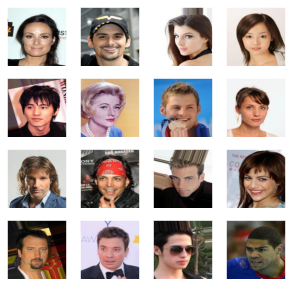

In [9]:
# load data
dataset = np.concatenate([np.load(f"dataset/batch_{batch}.npy") for batch in range(4)])
dataset = np.array([np.array(Image.fromarray(img).resize((img_width, img_height))) for img in dataset])
dataset = dataset.astype("float32") / 255.0
dataset = dataset[:1000]
show_images_grid(4, 4, *dataset[:16], figsize=(5, 5))

# Pre-processing

In [0]:
trainY, testY = train_test_split(dataset, train_size = 0.75)

In [0]:
#@title apply noise to images


noise_datasets = {
    "gauss_noise" : [apply_noise(trainY, gauss_noise), apply_noise(testY, gauss_noise)],
    "salt and pepper": [apply_noise(trainY, salt_pepper),apply_noise(testY, salt_pepper)],
    "poisson": [apply_noise(trainY, poisson), apply_noise(testY, poisson)],
    "Multiplicativa" : [apply_noise(trainY, speckle), apply_noise(testY, speckle)]
}

evaluation_funcs = {"absolute_error":absolute_error}
filters = {"median": median_each, "mean": mean_each, "majority": majority_filter}

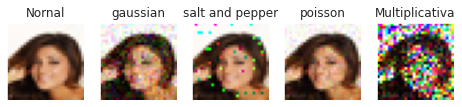

In [0]:
#@title show noise image sample
 

idx = 10
img_gauss = noise_datasets["gauss_noise"][1][idx]
img_salt_pepper = noise_datasets["salt and pepper"][1][idx]
img_poisson = noise_datasets["poisson"][1][idx]
img_mult = noise_datasets["Multiplicativa"][1][idx]
show_images_grid(1, 5, testY[idx], img_gauss, img_salt_pepper,
                 img_poisson, img_mult, figsize=(8, 8),
                 titles=["Nornal","gaussian","salt and pepper","poisson","Multiplicativa"])

In [0]:
#@title evaluate filters

from itertools import product

results = []
for noise_dataset_name, evaluation_func_name, filter_name in product(noise_datasets.keys(), evaluation_funcs.keys(), filters.keys()):
  print(noise_dataset_name)
  noise_dataset = noise_datasets[noise_dataset_name][1]
  evaluation_func = evaluation_funcs[evaluation_func_name]
  filter_func = filters[filter_name]
  filter_dataset = apply_filter(noise_dataset, filter_func)//255
  errors = evaluate(dataset, filter_dataset, evaluation_func)
  mean_errors = np.mean(errors)
  std_errors = np.std(errors)
  results.append({"noise method": noise_dataset_name, "evaluation metric": evaluation_func_name,
                  "filter used": filter_name, "mean error": mean_errors, "std error": std_errors})



# Autoencoders

In [0]:
#@title Train an model for each noise method


from tensorflow.keras.optimizers import Adam
from autoencoder import ConvAutoencoder

def build_autoencoder():
  (encoder, decoder, autoencoder) = ConvAutoencoder.build(img_width, img_height, channels)

  opt = Adam(lr=1e-3)
  autoencoder.compile(loss="mse", optimizer=opt)

  return autoencoder, encoder, decoder


epochs = 25
batch_size = 32
autoencoders = []
for noise_method_name, (trainX, testX) in list(noise_datasets.items()):
  autoencoder, _, _ = build_autoencoder()
  autoencoder.fit(trainX, trainY,
	validation_data=(testX, testY),
	epochs=epochs,
	batch_size=batch_size)
  autoencoders.append(autoencoder)



In [0]:
#@title example autoencoders results
imgs = []
imgs_titles = []
for i, (noise_method_name, (trainX, testX)) in enumerate(list(noise_datasets.items())):
  autoencoder = autoencoders[i]
  pred_test = autoencoder.predict(testX)
  for j, (img_testX, img_pred) in enumerate(zip(testX[:2], pred_test[:2])):
    imgs = imgs + [testY[j], img_testX, img_pred]
    imgs_titles = imgs_titles + ["Normal image", f"{noise_method_name}", "Autoencoder"]

show_images_grid(4, 6, *imgs, titles=imgs_titles, figsize=(10, 7))

In [0]:
#@title calculate autoencoders absolute errors

autoencoders_errors = []
for i, (noise_method_name, (trainX, testX)) in enumerate(list(noise_datasets.items())):
  autoencoder = autoencoders[i]
  pred_test = autoencoder.predict(testX)
  errors = evaluate(dataset, filter_dataset, absolute_error)
  mean_errors = np.mean(errors)
  std_errors = np.std(errors)
  autoencoders_errors.append({"noise method": noise_method_name, "evaluation metric": "absolute_error",
                  "filter used": "autoencoder", "mean error": mean_errors, "std error": std_errors})
  

autoencoders_errors

In [0]:
#@title Plot absolute image denoising errors
# Bar plot error
import pandas as pd

dataframe_results = pd.DataFrame(autoencoders_errors+results)
fig = plt.figure(figsize=(10, 10))
sns.barplot(data=dataframe_results, y="mean error", x="noise method", hue="filter used")

In [0]:
#@title Show images sample of each denosing method
imgs = []
imgs_titles = []
for i, (noise_method_name, (trainX, testX)) in enumerate(list(noise_datasets.items())):
  autoencoder = autoencoders[i]
  pred_test = autoencoder.predict(testX)
  for j, (img_testX, img_pred) in enumerate(zip(testX[:2], pred_test[:2])):
    imgs = imgs + [testY[j], img_testX, img_pred]
    imgs = imgs + [testY[j], img_testX, mean_each(img_testX)]
    imgs = imgs + [testY[j], img_testX, median_each(img_testX)]
    imgs = imgs + [testY[j], img_testX, majority_filter_v2(img_testX)]
    imgs_titles = imgs_titles + ["Normal image", f"{noise_method_name}", "Autoencoder"]
    imgs_titles = imgs_titles + ["Normal image", f"{noise_method_name}", "Mean Filter"]
    imgs_titles = imgs_titles + ["Normal image", f"{noise_method_name}", "median Filter"]
    imgs_titles = imgs_titles + ["Normal image", f"{noise_method_name}", "majority Filter"]

show_images_grid(16, 6, *imgs, titles=imgs_titles, figsize=(10, 30))

# Pix2pix (GAN)

In [0]:
#@title install dependencies


!git clone https://www.github.com/keras-team/keras-contrib.git
!cd keras-contrib && python setup.py install
!pip install --upgrade scikit-image
!pip install -U keras==2.3.0

In [0]:
#@title Train pix2pix denoise model

from pix2pix import Pix2Pix
selected_noise = "gauss_noise"
trainX, testX = noise_datasets[selected_noise]

train = np.array([get_concat_h(trainy, trainx) for trainx, trainy in zip(trainX, trainY)])
test = np.array([get_concat_h(trainy, trainx) for trainx, trainy in zip(testX, testY)])
test, val = test[:int(len(test)*0.90)], test[int(len(test)*0.90):]

model = Pix2Pix(f"celebfaces_{selected_noise}", 256, 256, 3, train, test, val)
model.train(epochs=10, batch_size=32, sample_interval=100)

In [19]:
#@title Calculate mean absolute error for trained model

test_pred = model.generator.predict((testX*255).astype("uint8")/127.5 - 1)
test_pred = test_pred * 0.5 + 0.5
errors = evaluate(test_pred, testX, absolute_error)
mean_errors = np.mean(errors)
std_errors = np.std(errors)

print(mean_errors, std_errors)

0.11733122518516075 0.01070758638587904


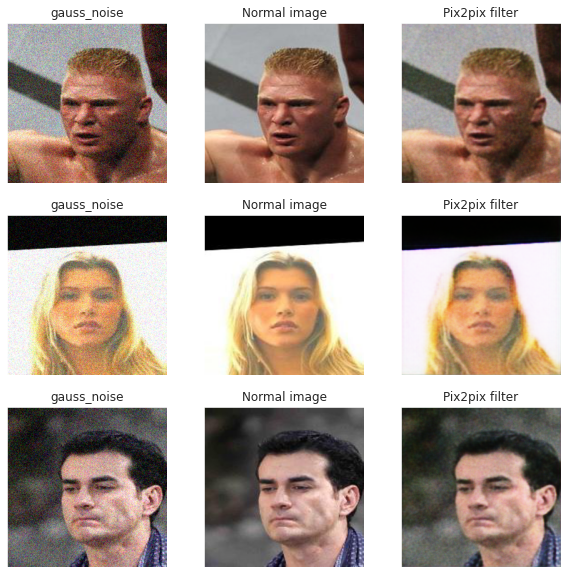

In [28]:
#@title show example of images denoised with Pix2pix
 

test_pred = model.generator.predict((testX*255).astype("uint8")/127.5 - 1)
test_pred = test_pred * 0.5 + 0.5
imgs = []
titles = []
for testx, testy, test_pred in zip(testX, testY, test_pred):
  imgs = imgs + [testx, testy, test_pred]
  titles = titles + [f"{selected_noise}", "Normal image", "Pix2pix filter"]

show_images_grid(3, 3, *imgs[:9], titles=titles, figsize=(10, 10))